In [1]:
import sys
import os
from utils import *

/home/ljaffeux/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-06-03 11:39:12.700954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748943552.826292   67656 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748943552.861922   67656 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 11:39:13.132563: I tensorflow/core/platform/cpu_f

# Define sequence length, sampling rate, features, and data set to use for training (reference)
# Name the version, and add observations if needed

In [26]:
timesteps = 120 # Length of sequence
resampling ='5s' # Time spacing
data_root='../Data'
features = ['AOA_RAD', 'AOS_RAD','PITCH','ROLL','GROUND_SPEED','VERTICAL_SPEED','TAS'] # Key features you want to learn may add ['AOA_RAD', 'AOS_RAD','PITCH','ROLL','TAS']
# ,'VERTICAL_WIND','NORTHWARD_WIND','EASTWARD_WIND'
# Define campàaign to learn from
campaigns = ['LIAISE','EUREC4A'] # Can use more than one campaign for gathering training data set
INSs = ['IMU1']
# Version for archiving
version = 'LIAISE_5Hz'
# Additional informations you might want to add to the configfile (will be read once you load the data)
observations = '' 

# Loads or format the data, scale it, and split into <span style="color:red">training</span>, <span style="color:blue">validation</span> and <span style="color:green">testing</span> sets (<span style="color:red">64%</span>, <span style="color:blue">20%</span>, <span style="color:green">16%</span>)


In [27]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer()

def create_sequences(data, timesteps):
    data.dropna()
    sequences = []
    for i in range(len(data) - timesteps):
        sequences.append(data[i : i + timesteps])  # Extract time window
    return np.array(sequences)
    
train_data = []
version_dir = f'Anomaly_detection/{version}'
config_path = os.path.join(version_dir, "config.txt")

if os.path.exists(version_dir) and os.path.exists(os.path.join(version_dir, 'X_data.npy')):
    print(f"✅ Found saved data in {version_dir}. Loading...")
    X_data = np.load(os.path.join(version_dir, 'X_data.npy'))
    scaler = joblib.load(os.path.join(version_dir, 'scaler_train.pkl'))
    data_scaled = scaler.transform(X_data.reshape(-1, X_data.shape[-1])).reshape(X_data.shape)
    X_train = data_scaled
    print(f"✅ {version} loaded and scaled")
    # Read and display config
    if os.path.exists(config_path):
        print(f"📄 Configuration loaded from {config_path}:")
        with open(config_path, "r") as f:
            for line in f:
                print("   ", line.strip())
else:
    print(f"❌ No saved data in {version_dir}.")
    print("🔄 Processing data from scratch...")
    # Save model configuration variables
    os.makedirs(f'{version_dir}')
    with open(config_path, "w") as f:
        f.write(f"timesteps = {timesteps}\n")
        f.write(f"resampling = '{resampling}'\n")
        f.write(f"data = '{campaigns}'\n")
        f.write(f"INS = '{INSs}'\n")
        f.write(f"features = {features}\n")
        f.write(f"version = {version}\n")
        f.write(f"observations = {observations}\n")

    for campaign,INS in zip(campaigns,INSs) :
        if not campaign == 'MAESTRO':
            INS=''
        segmentation_dir = f'{data_root}/Segmentation_default/{campaign}/{INS}'
        raw_data_dir = f'{data_root}/Raw'
        if not os.path.exists(segmentation_dir):
            print(f"Segmentation directory not found: {segmentation_dir}")
        
        for fname in tqdm(os.listdir(segmentation_dir)):
            if not fname.endswith('.yaml'):
                continue
        
            flight_number = extract_flight_number(fname)
            if flight_number is None:
                continue
            if flight_number < 200009 and campaign == 'EUREC4A': # Special condition for EUREC4A
                print(f'Skipping bad EUREC4A flight {flight_number}')
                continue
        
            try:
                yaml_path = os.path.join(segmentation_dir, fname)
        
                # Match raw data folder
                matching_raw_folder = [f for f in os.listdir(raw_data_dir)
                                       if os.path.isdir(os.path.join(raw_data_dir, f)) and campaign in f and INS in f]
                if not matching_raw_folder:
                    print(f"❌ No raw folder found for {campaign} {INS}")
                    continue
        
                raw_folder = os.path.join(data_root, 'Raw', matching_raw_folder[0])
                # Look for any .nc file containing the flight number
                flight_str = f'{flight_number:02d}'
                nc_candidates = [f for f in os.listdir(raw_folder)
                                 if f.endswith('.nc') and flight_str in f]
                
                if not nc_candidates:
                    print(f"❌ No matching .nc file found for flight {flight_number} in {raw_folder}")
                    continue
                
                nc_path = os.path.join(raw_folder, nc_candidates[0])  # Use first match
                # print(f"  - Loading NetCDF: {nc_candidates[0]}")
        
                yaml_data = read_yaml(yaml_path)
                df_raw = load_raw_data(nc_path)
                if 'GROUND_SPEED' in features:
                    df_raw['GROUND_SPEED'] = np.sqrt(df_raw['NORTH_SPEED']**2 + df_raw['EAST_SPEED']**2)
                if 'SIDESLIP_RAD' in df_raw.columns:
                    df_raw['AOS_RAD'] = df_raw['SIDESLIP_RAD']
                if (campaign,INS)==('MAESTRO','IMU2'):
                    df_raw['AOS_RAD'] = df_raw['AOS_RAD'] - np.radians(0.545)
                train_data.extend(create_sequences(df_raw[features].resample(resampling).mean().dropna(), timesteps))
            except Exception as e:
                print(f"❌ Error in flight {flight_number}: {e}")
        
    X_data = train_data
    # save data for time
    np.save(f"{version_dir}/X_data.npy", X_data)
    # Scale the data
    data_reshaped = np.array(X_data).reshape(-1, np.array(X_data).shape[-1])  # Reshape for scaling
    data_scaled = scaler.fit_transform(data_reshaped).reshape(np.array(X_data).shape)
    # Save scaler for future usage
    joblib.dump(scaler, f"{version_dir}/scaler_train.pkl")
    print(f"✅ {version} saved and scaled")
    
X_train = data_scaled
# Create train-test split
train_data, test_data = train_test_split(X_train, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)
# Define the LSTM Autoencoder model
timesteps = train_data.shape[1]  # Number of timesteps
n_features = train_data.shape[2]  # Number of features

❌ No saved data in Anomaly_detection/LIAISE_5Hz.
🔄 Processing data from scratch...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:46<00:00,  5.79s/it]


✅ LIAISE_5Hz saved and scaled


# Fine tuning and training with LSTM - CNN hybrid model

Trial 1 Complete [00h 00m 33s]
val_loss: 0.04259469360113144

Best val_loss So Far: 0.04259469360113144
Total elapsed time: 00h 00m 33s
Epoch 1/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - loss: 0.0834 - mae: 0.2247 - val_loss: 0.0485 - val_mae: 0.1756
Epoch 2/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - loss: 0.0459 - mae: 0.1677 - val_loss: 0.0441 - val_mae: 0.1638
Epoch 3/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 0.0436 - mae: 0.1617 - val_loss: 0.0433 - val_mae: 0.1621
Epoch 4/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 0.0432 - mae: 0.1604 - val_loss: 0.0420 - val_mae: 0.1591
Epoch 5/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - loss: 0.0409 - mae: 0.1555 - val_loss: 0.0395 - val_mae: 0.1539
Epoch 6/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 0.0393 - mae: 0.1524 - val_loss: 0.0388 - val_mae: 0.1510
Epoch 7/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 0.0379 - mae: 0.1490 - val_loss: 0.0365 - val_mae: 0.1458
Epoch 8/20

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_8 (InputLayer)     │ (None, 120, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 120, 16)        │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 60, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 120, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120, 16)        │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 120, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 120, 7)         │           119 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,960 (42.82 KB)

 Trainable params: 5,479 (21.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,481 (21.41 KB)

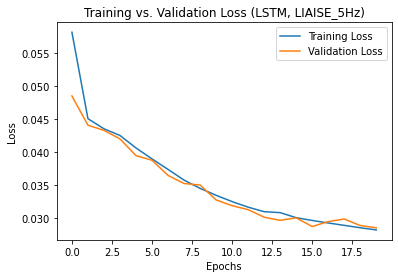

In [28]:
input_shape = (timesteps, n_features)  # timesteps and n_features should be defined

# Function to build model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt  # Only if you're using hyperparameter tuning

def build_model(hp):
    input_layer = Input(shape=input_shape)

    # CNN Encoder
    x = Conv1D(
        filters=hp.Choice('conv1_filters', values=[16, 32, 64]), 
        kernel_size=hp.Choice('conv1_kernel', values=[3, 5]), 
        activation='relu', 
        padding='same'
    )(input_layer)
    x = MaxPooling1D(2)(x)
    x = Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = Conv1D(
        filters=hp.Choice('conv2_filters', values=[32, 64, 128]), 
        kernel_size=hp.Choice('conv2_kernel', values=[3, 5]), 
        activation='relu', 
        padding='same'
    )(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1))(x)

    # LSTM Encoder (return_sequences=True for extraction)
    x = LSTM(
        hp.Choice('lstm_units', values=[32, 64, 128]), 
        activation='relu', 
        return_sequences=True  # Keep sequences for later extraction
    )(x)
    x = Dropout(hp.Float('dropout4', min_value=0.1, max_value=0.5, step=0.1))(x)

    # Decoder LSTM
    x = RepeatVector(timesteps)(x[:, -1, :])  # Use last LSTM output
    x = LSTM(
        hp.Choice('lstm_dec_units', values=[32, 64, 128]), 
        activation='relu', 
        return_sequences=True
    )(x)
    x = Dropout(hp.Float('dropout5', min_value=0.1, max_value=0.5, step=0.1))(x)

    # CNN Decoder
    x = Conv1D(
        filters=hp.Choice('conv4_filters', values=[32, 64, 128]), 
        kernel_size=hp.Choice('conv4_kernel', values=[3, 5]), 
        activation='relu', 
        padding='same'
    )(x)
    x = Dropout(hp.Float('dropout6', min_value=0.1, max_value=0.5, step=0.1))(x)    

    x = Conv1D(
        filters=hp.Choice('conv6_filters', values=[32, 64, 128]), 
        kernel_size=hp.Choice('conv6_kernel', values=[3, 5]), 
        activation='relu', 
        padding='same'
    )(x)
    x = Dropout(hp.Float('dropout8', min_value=0.1, max_value=0.5, step=0.1))(x)

    # Output Layer
    output_layer = TimeDistributed(Dense(n_features))(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile with tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse'
    )

    return model  # Only return ONE model

def build_simple_model(hp):
    input_layer = Input(shape=input_shape)

    # Simple CNN Encoder
    x = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(2)(x)

    # Simple LSTM Encoder
    x = LSTM(16, activation='relu', return_sequences=False)(x)

    # Repeat vector for decoder
    x = RepeatVector(timesteps)(x)
    x = LSTM(16, activation='relu', return_sequences=True)(x)

    # Simple CNN Decoder
    x = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(x)

    # Output Layer
    output_layer = TimeDistributed(Dense(n_features))(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    return model

# Hyperparameter Tuner
tuner = kt.RandomSearch(
    build_simple_model,
    objective='val_loss',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  
    directory=f'Anomaly_detection/tuner_results_{version}_simple',
    project_name='LSTM_CNN'
)

# Search for the best hyperparameters
tuner.search(train_data, train_data,
             epochs=1, batch_size=16, validation_data=(val_data, val_data), verbose=1)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

auto_best = tf.keras.models.clone_model(best_model)
# Train best model
auto_best.compile(
        loss='mse',
        metrics=['mae'])
# Retrieve best model after training


history = auto_best.fit(
    train_data, train_data,
    epochs=20,
    batch_size=16,
    validation_data=(val_data, val_data),
    verbose=1,
)
# Display summary of the best model
auto_best.summary()
auto_best.save(f'{version_dir}/LSTM_CNN.keras')

# Loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training vs. Validation Loss (LSTM, {version})')
plt.savefig(f'{version_dir}/Training_LSTM_CNN.png')
plt.show()

# Fine tuning and training with Attention model (attention is all you need !)

In [20]:
input_shape = (timesteps, n_features)  # timesteps and n_features should be defined

# Self-Attention Layer
@register_keras_serializable(package="Custom")
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.num_heads = num_heads

    def build(self, input_shape):
        self.query_dense = Dense(input_shape[-1])
        self.key_dense = Dense(input_shape[-1])
        self.value_dense = Dense(input_shape[-1])
        self.attention = Attention()
        self.layer_norm = LayerNormalization()

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        attention_output = self.attention([query, key, value])
        return self.layer_norm(attention_output + inputs)  # Residual Connection


# CNN-LSTM-Attention Autoencoder
def build_attention_model(hp):
    input_layer = Input(shape=input_shape)
    # CNN Encoder
    x = Conv1D(filters=hp.Choice('conv1_filters', values=[16, 32, 64]), 
               kernel_size=hp.Choice('conv1_kernel', values=[3, 5]), 
               activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(2)(x)
    x = Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1))(x)

    # BiLSTM Encoder
    x = Bidirectional(LSTM(hp.Choice('lstm_units', values=[32, 64, 128]), return_sequences=True))(x)

    # Self-Attention Mechanism
    x = SelfAttention(num_heads=4)(x)

    # Latent Representation
    x = LSTM(hp.Choice('latent_dim', values=[16, 32, 64]), activation='relu', return_sequences=False)(x)
    
    # Decoder
    x = RepeatVector(timesteps)(x)
    x = LSTM(hp.Choice('lstm_dec_units', values=[32, 64, 128]), return_sequences=True)(x)

    # CNN Decoder
    x = Conv1D(filters=hp.Choice('conv4_filters', values=[32, 64, 128]), 
               kernel_size=hp.Choice('conv4_kernel', values=[3, 5]), 
               activation='relu', padding='same')(x)
    x = Dropout(hp.Float('dropout6', min_value=0.1, max_value=0.5, step=0.1))(x)

    # Output Layer
    output_layer = TimeDistributed(Dense(n_features))(x)

    # Define Model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss="mse"
    )

    return model

# Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_attention_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory=f'Anomaly_detection/tuner_results_{version}',
    project_name='Attention'
)

# Search for the best hyperparameters
tuner.search(train_data, train_data,
             epochs=10, batch_size=16, validation_data=(val_data, val_data), verbose=1)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

auto_best = tf.keras.models.clone_model(best_model)
# Train best model
auto_best.compile(
        loss='mse',
        metrics=['mae'])

history = auto_best.fit(
    train_data, train_data,
    epochs=20,
    batch_size=16,
    validation_data=(val_data, val_data),
    verbose=1,
)
# Display summary of the best model
auto_best.summary()
auto_best.save(f'{version_dir}/Attention.keras')

# Loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training vs. Validation Loss (Attention, {version})')
plt.savefig(f'{version_dir}/Training_Attention.png')
plt.show()

Trial 4 Complete [00h 07m 08s]
val_loss: 0.026704970747232437

Best val_loss So Far: 0.026704970747232437
Total elapsed time: 01h 10m 06s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
64                |64                |conv1_filters
3                 |5                 |conv1_kernel
0.2               |0.4               |dropout1
128               |128               |lstm_units
16                |16                |latent_dim
64                |128               |lstm_dec_units
64                |128               |conv4_filters
3                 |5                 |conv4_kernel
0.2               |0.3               |dropout6
0.0001            |0.001             |learning_rate

Epoch 1/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - loss: 0.1042 - val_loss: 0.0462
Epoch 2/10
337/614 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0575

KeyboardInterrupt: 

# Conditional Forecasting
## Predicts future wind vectors given the recent history of attitude and wind, and the future attitude parameters

# Basic Visualization, shows 10 examples from the test set (never seen during training)

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
-----------------------------


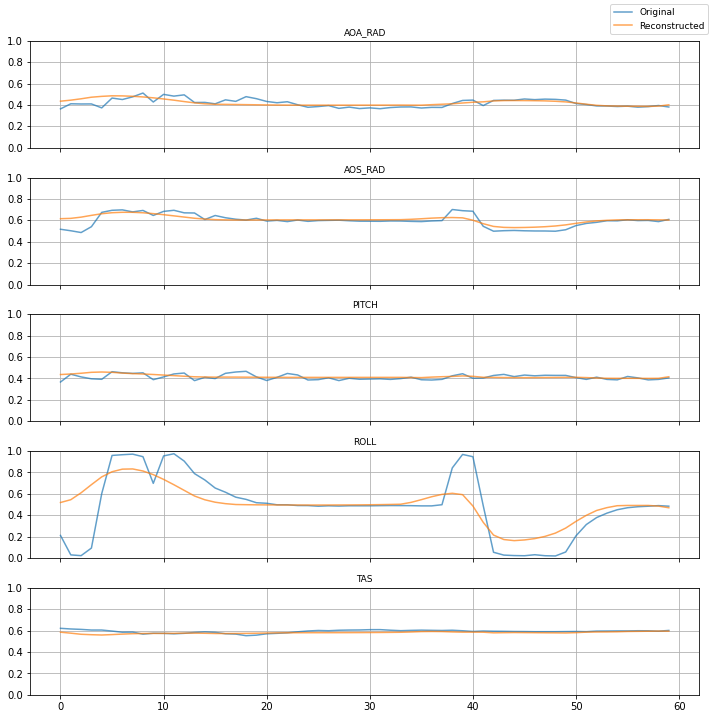

-----------------------------


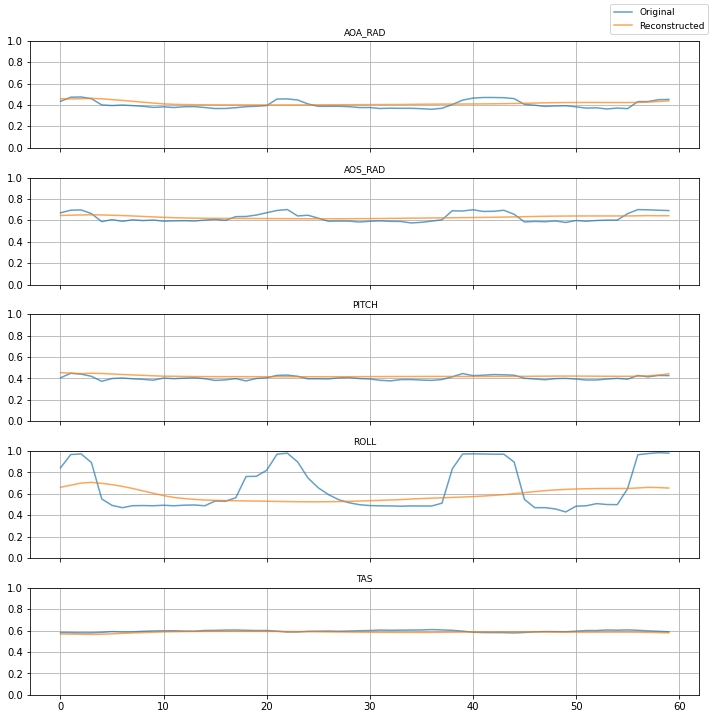

-----------------------------


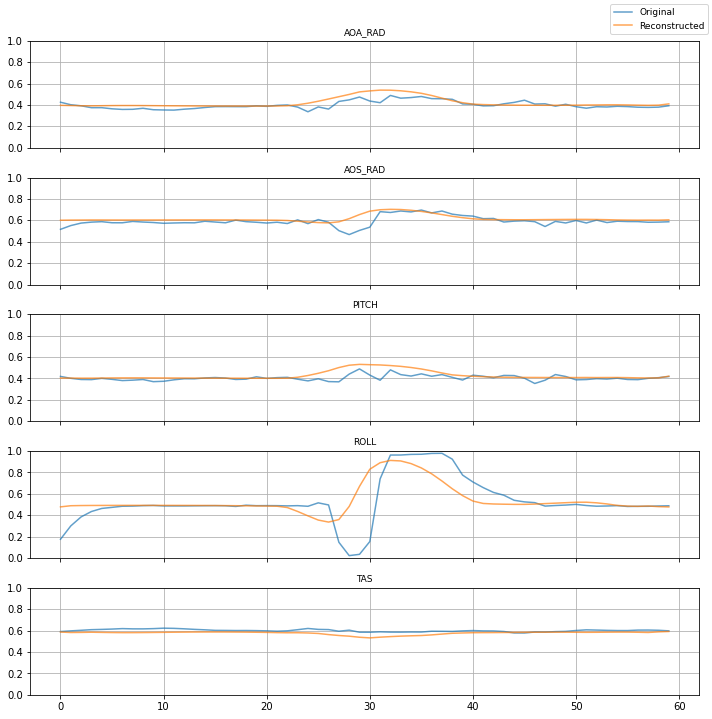

-----------------------------


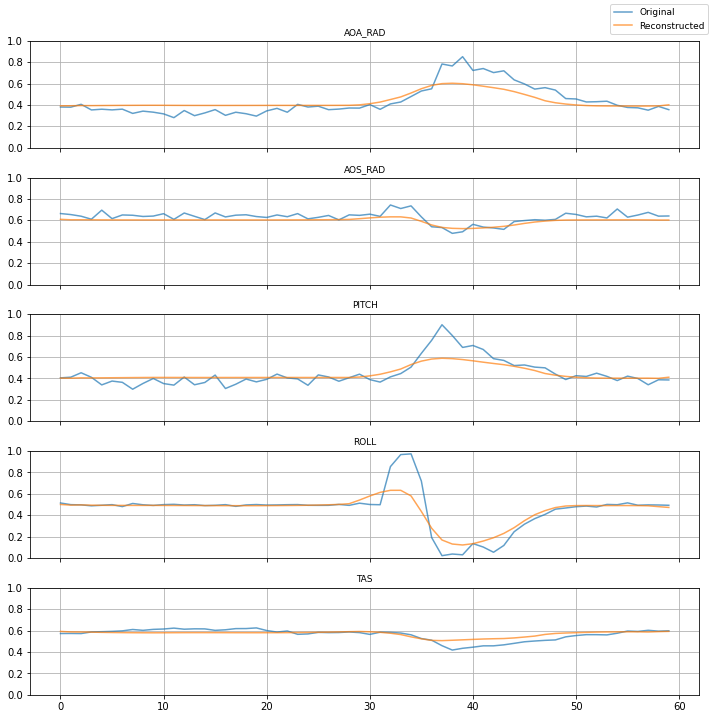

-----------------------------


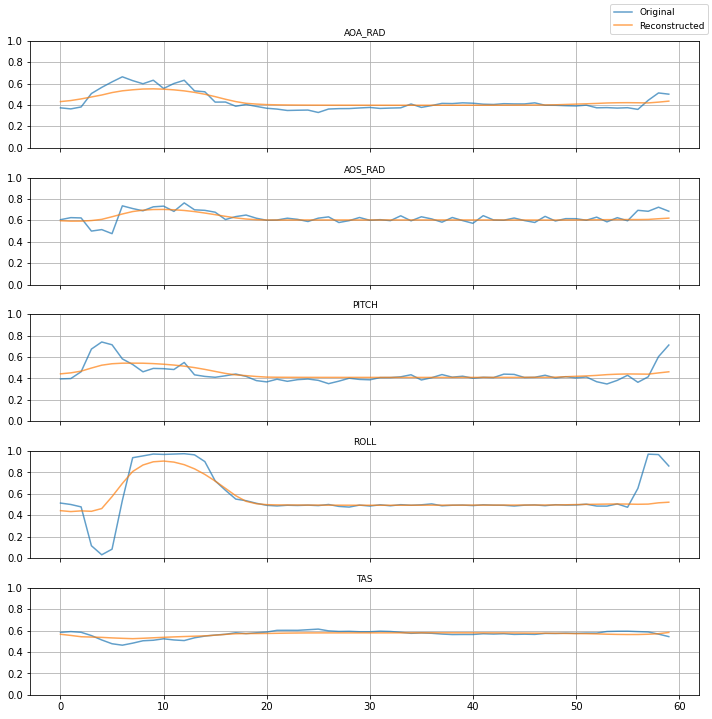

-----------------------------


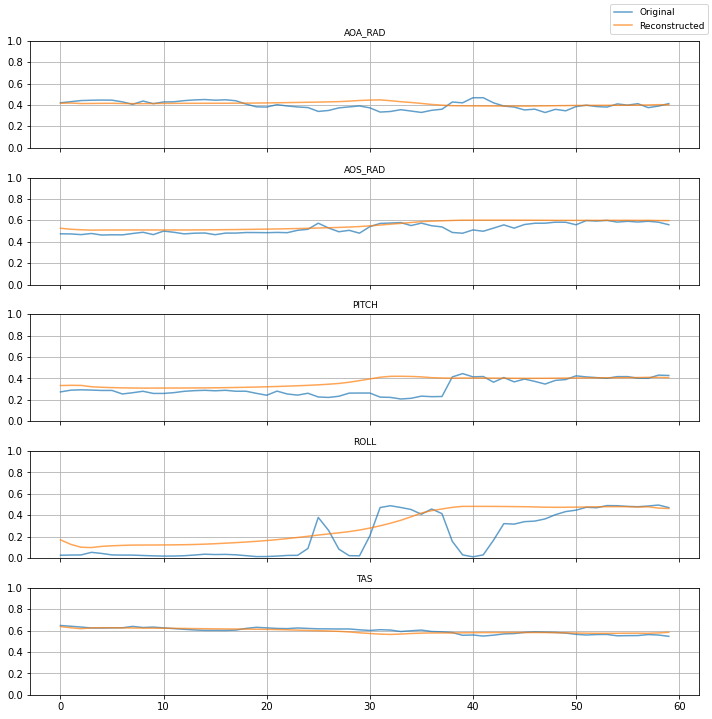

-----------------------------


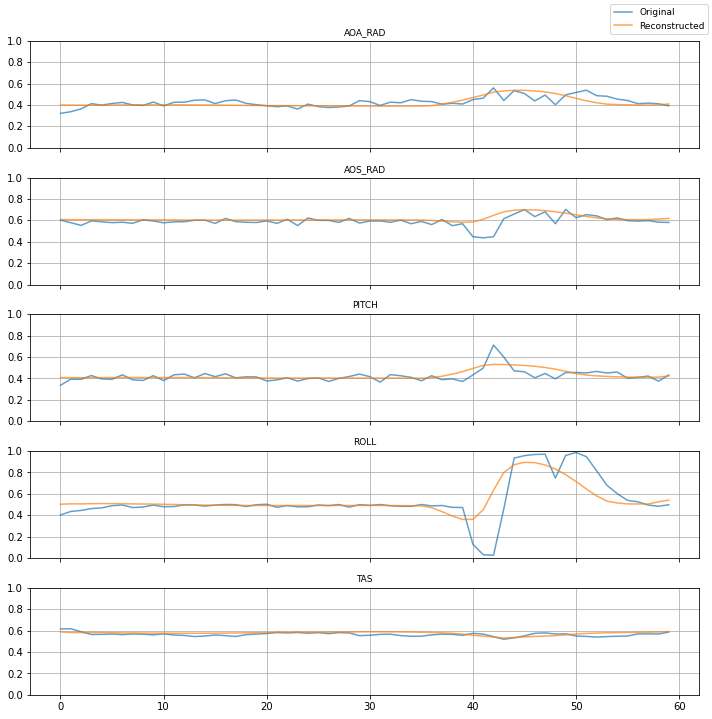

-----------------------------


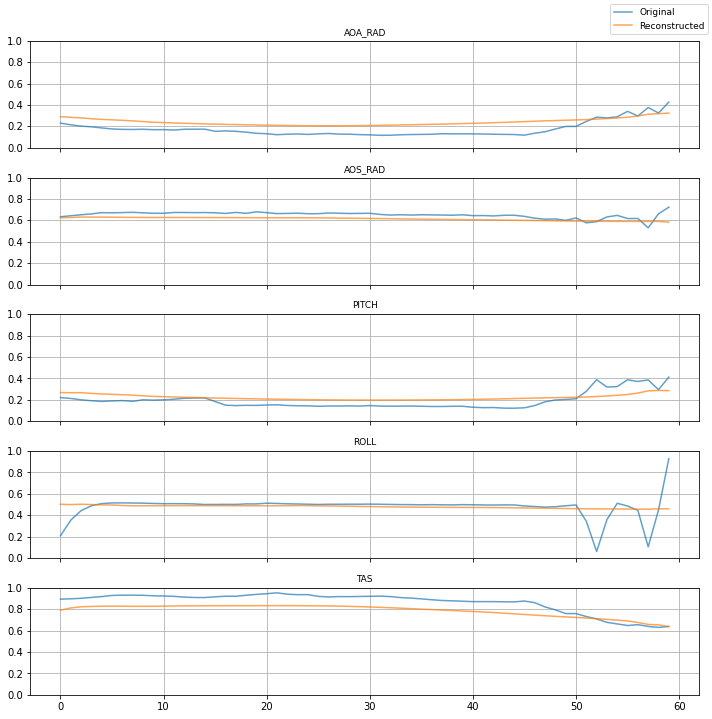

-----------------------------


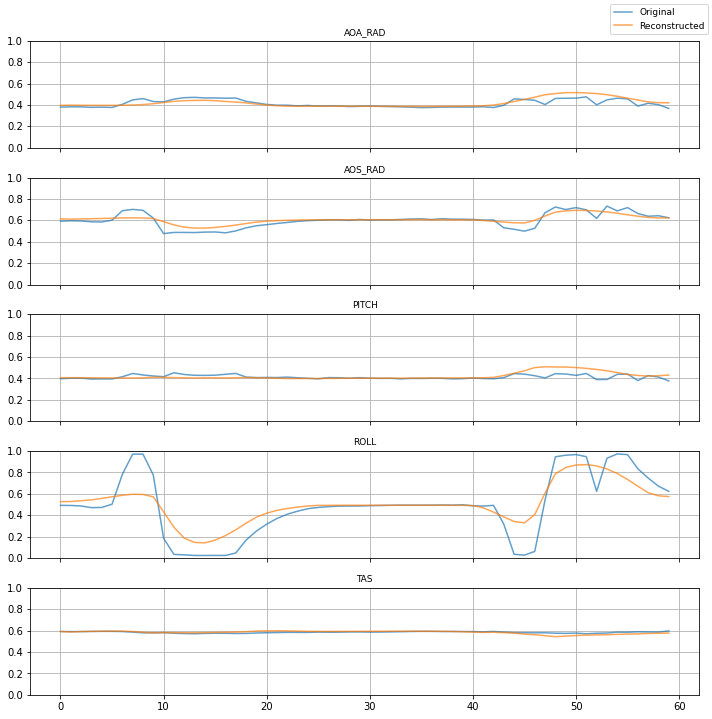

-----------------------------


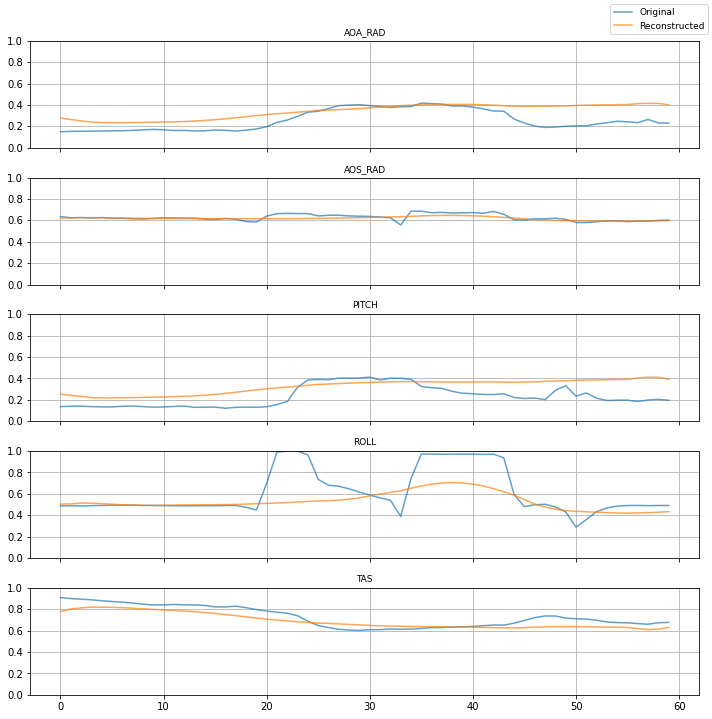

In [40]:
reconstructed_data = auto_best.predict(test_data)

for sample_index in range(10):
    print('-----------------------------')
    original_sample = test_data[sample_index]
    reconstructed_sample = reconstructed_data[sample_index]

    n_features = original_sample.shape[1]
    fig, axs = plt.subplots(n_features, 1, figsize=(5*2, n_features * 2), sharex=True, sharey=True)
    
    if n_features == 1:
        axs = [axs]  # Make iterable if only one feature

    for i, ax in enumerate(axs):
        ax.plot(original_sample[:, i], label='Original', alpha=0.7)
        ax.plot(reconstructed_sample[:, i], label='Reconstructed', alpha=0.7)
        ax.set_title(f'{features[i]}', fontsize=9)
        ax.set_ylim([0, 1])
        ax.grid(True)

    # Use a single legend for the entire figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()